In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/parent_TRAIN_VAL_AUGMENTED/augmeneted_latest_4_class", output="train_val-augmented",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 3101 files [00:43, 72.05 files/s] 


In [5]:
train_dir = "/content/train_val-augmented/train"
val_dir = "/content/train_val-augmented/val"
test_dir = "/content/drive/MyDrive/parent_TRAIN_VAL_AUGMENTED/test"

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                          # featurewise_center=True,
                                                          # featurewise_std_normalization=True,
                                                          # rotation_range=90,
                                                          # width_shift_range=0.2,
                                                          # height_shift_range=0.2,
                                                          # horizontal_flip=True,
                                                          # zoom_range=0.2,
                                                          )

In [7]:
train_gen = datagen.flow_from_directory(train_dir,
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                        shuffle=True,
                                                 class_mode = 'categorical')
test_gen= datagen.flow_from_directory(test_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                      shuffle=False,
                                            class_mode ='categorical')
val_gen = datagen.flow_from_directory(val_dir,
                                            target_size = (224,224),
                                            batch_size = 32,
                                      shuffle=True,
                                          class_mode = 'categorical')

Found 2479 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 622 images belonging to 4 classes.


In [8]:
# IMG_SIZE = (224, 224)

# train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  shuffle=True,
#                                                                  batch_size=32)


# test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  batch_size=32,
#                                                                 shuffle=False)

# val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
#                                                                  image_size=IMG_SIZE,
#                                                                  label_mode="categorical",
#                                                                  batch_size=32,
#                                                                 shuffle=True)

In [9]:
# Visualizing data
import os 
def visualize_random_images(dataset_type="train", label_type="Monkeypox"):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

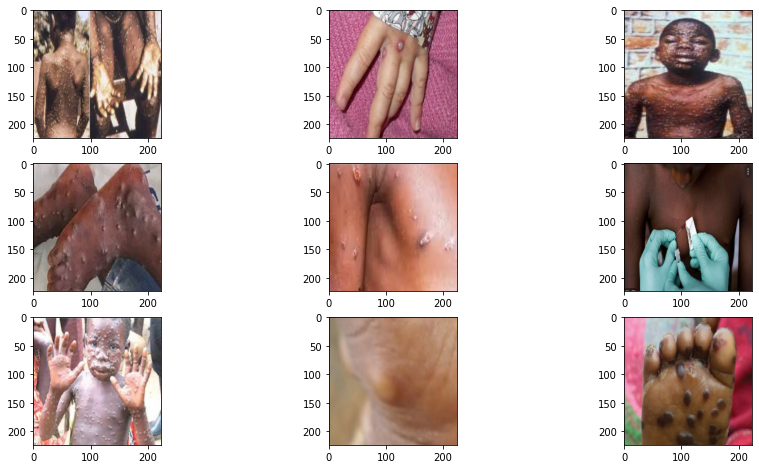

In [10]:
visualize_random_images("/content/train_val-augmented/train/monkeypox_TV_augmented/dr_0_1404.jpg")

In [11]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [12]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.2)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(512, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(512, activation="relu")(dropout_layer_2)
outputs = layers.Dense(4, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

43950080/43941136 [==============================] - 0s 0us/step


In [13]:
# base_model = tf.keras.applications.MobileNetV2(include_top=False)
# base_model.trainable = False

# for layer in base_model.layers[:-5]:
#   layer.trainable = False

# inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
# base_layer = base_model(inputs)

# flat_layer = layers.Flatten()(base_layer)

# outputs = layers.Dense(4, activation="softmax")(flat_layer)
# model = Model(inputs, outputs)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adadelta (lr=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_gen,
                       epochs=40,
                       validation_data=val_gen)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


Epoch 1/40
78/78 [==============================] - 36s 203ms/step - loss: 1.4054 - accuracy: 0.3534 - val_loss: 1.1358 - val_accuracy: 0.5273
Epoch 2/40
78/78 [==============================] - 12s 159ms/step - loss: 1.0850 - accuracy: 0.5514 - val_loss: 0.9493 - val_accuracy: 0.6592
Epoch 3/40
78/78 [==============================] - 13s 161ms/step - loss: 0.9253 - accuracy: 0.6474 - val_loss: 0.8309 - val_accuracy: 0.7138
Epoch 4/40
78/78 [==============================] - 13s 162ms/step - loss: 0.8063 - accuracy: 0.7023 - val_loss: 0.7410 - val_accuracy: 0.7588
Epoch 5/40
78/78 [==============================] - 13s 164ms/step - loss: 0.7193 - accuracy: 0.7515 - val_loss: 0.6730 - val_accuracy: 0.7878
Epoch 6/40
78/78 [==============================] - 13s 168ms/step - loss: 0.6576 - accuracy: 0.7781 - val_loss: 0.6196 - val_accuracy: 0.8055
Epoch 7/40
78/78 [==============================] - 13s 167ms/step - loss: 0.5913 - accuracy: 0.8120 - val_loss: 0.5751 - val_accuracy: 0.8280

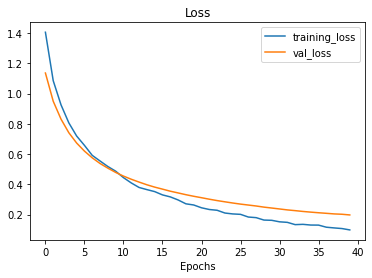

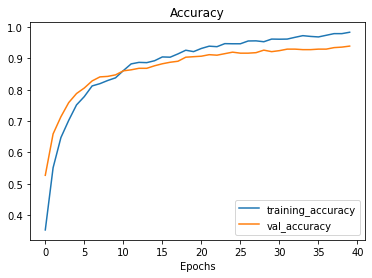

In [15]:
plot_loss_curves(history)

In [16]:
# model.evaluate(test_data)

In [17]:
# y_pred = tf.math.round(model.predict(test_gen))
# y_true = []
# for images, labels in test_gen.unbatch():
#   y_true.append(labels.numpy())

In [18]:
# accuracy_score(y_true, y_pred)

In [19]:
# print(classification_report(y_true, y_pred, target_names=train_data.class_names))

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
import numpy as np
print("==============TEST RESULTS============")

num_classes = len(train_gen.class_indices)
test_labels = test_gen.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)
y_true = [i.argmax() for i in test_labels]

predictions = model.predict(test_gen, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
confusion_mtx = confusion_matrix(true_classes, yPredictions) 
y_pred_probabilities=yPredictions
classnames=[]
for classname in test_gen.class_indices:
    classnames.append(classname)

target_names = classnames
print(classification_report(true_classes, yPredictions, target_names=target_names))

# print('roc_auc_score = ' + str(roc_auc_score( true_classes, yPredictions)))

==============TEST RESULTS============
3/3 [==============================] - 13s 6s/step
              precision    recall  f1-score   support

  Chickenpox       0.82      0.82      0.82        11
     Measles       0.91      1.00      0.95        10
   Monkeypox       0.86      0.86      0.86        28
      Normal       0.97      0.93      0.95        30

    accuracy                           0.90        79
   macro avg       0.89      0.90      0.89        79
weighted avg       0.90      0.90      0.90        79



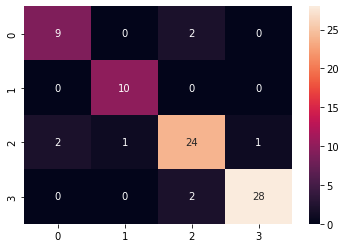

In [21]:

sns.heatmap(confusion_mtx.astype("int"), annot=True)

In [22]:
model.save('monkeypox_EfficientNetB3_with_Transferlearnig_on_Augmented_95.h5')